In [403]:
#imports
import sys
import scipy.constants as con
import scipy.optimize as opt
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack

import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

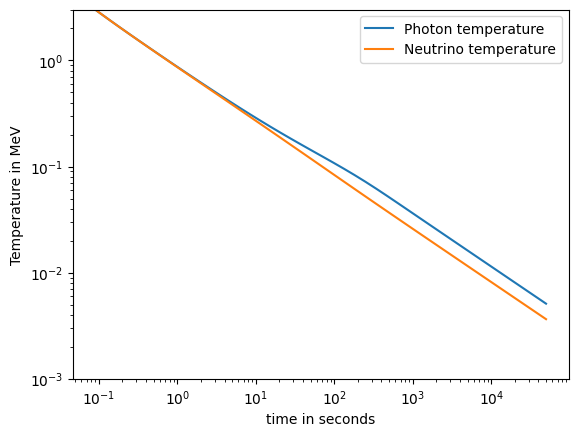

In [404]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
T_ini=3          #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a)+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


In [405]:
#Load networks
import bbn_test_integrate as bbn_n
import He4_test_integrate as He4_n

In [406]:
#Initial conditions for Simple network

#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions
nNucs_ini=6
Y_ini=np.zeros(nNucs_ini)+1e-40
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_nHe3(T_ini)
Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)
print(Y_ini)

#compile rhs
He4_n.rhs(t_ini/timeunit, Y_ini,rho_b(1)*gcm3, T_ini*TMeV2T9*1e9)

dYdt_ini=lambda Y : He4_n.rhs(t_ini/timeunit, Y ,rho_b(1)*gcm3, T_ini*TMeV2T9*1e9)

#Find initial conditions from rhs
Y_initial=opt.fsolve(dYdt_ini, x0=Y_ini)

#use these initial conditions. 
Y_ini=abs(Y_initial/sum(Y_initial))


print(abs(Y_initial/sum(Y_initial)))
print(sum(Y_initial))
print(dYdt_ini(Y_ini))



[3.93887566e-01 6.06112434e-01 1.23110755e-12 2.76264842e-24
 3.30018800e-24 2.06194248e-29]
[3.92934586e-01 6.07065414e-01 1.24081001e-12 2.80796775e-24
 3.36247885e-24 5.14361064e-34]
0.9955779898291038
[-3.70984455e+07 -3.70984455e+07  3.70984455e+07  1.33900342e-10
  1.27890132e-10  3.54561885e-18]


In [431]:
#Combining background and simplified network

        # enumeration for different isotopes
        #  0   1   2   3    4     5
Y_labels=['n','p','d','t','He3','He4']
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
params_ini=[T_ini,1]+list(Y_ini)
#t_range=[t_ini,5e4*timeunit]
t_range=[0,5e4]

n_params_ini=nNucs_ini+n_bparams
sparcity=None#np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0
def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y)*timeunit,dadt(t,*y)*timeunit]

def ndall_ini(t,y):   #solve h and T, y[0] = T and y[1] = a      
    #print('rhs input'+str(y)) 
    output=ndbackground(t*timeunit,y[:n_bparams])+list( He4_n.rhs(t, y[n_bparams:],rho_b(y[1])*gcm3, y[0]*TMeV2T9*1e9))        
    #print('rhs output'+str(output)) 
    return output



In [432]:
#solving Simplified network for early times


def jacY_anal_ini(t,y):
    return He4_n.jacobian(t, y[n_bparams:],rho_b(y[1])*gcm3, y[0]*TMeV2T9*1e9)


Factor=None
def jacobian_ini(t,y):
    #print('jacobain input'+str(y))
    jac=np.append(np.zeros((nNucs_ini,n_bparams)),jacY_anal_ini(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params_ini)),jac,axis=0)
    
    

solY_ini = integrate.solve_ivp(ndall_ini, t_range, params_ini,method='Radau',atol=1e-40,rtol=1e-4,jac=jacobian_ini)#,t_eval=t_space)


abun=[abun[-1] for abun in solY_ini.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[7.369738283866639e-11, 0.7554398635549107, 3.8113596609243155e-05, 1.8469042587122183e-07, 2.333503090614222e-05, 0.24449850528927394]
sum:  1.000000002235823


In [430]:
solY_ini
t_ini/timeunit

0.08967888230561043

In [410]:
#1.252
#1.26

In [411]:
#Initial conditions for full network


#Initial conditions
nNucs=9
Y_synt=np.zeros(nNucs)+1e-40



#compile rhs
bbn_n.rhs(t_ini/timeunit, Y_ini,eta_ini*n_gamma_ini*1*gcm3, T_ini*TMeV2T9*1e9)

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,eta_ini*n_gamma_ini*m_p*gcm3, T_ini*TMeV2T9*1e9)

#Find initial conditions from rhs
Y_initial=opt.fsolve(dYdt_ini, x0=Y_ini)

#use these initial conditions. Currently won't converge
Y_ini[6:]=abs(Y_initial/sum(Y_initial))[6:]
#rhs(t, Y, rho, T):
#Y_ini[6]=abs(Y_initial/sum(Y_initial))[6]*0.9
#Y_ini[8]=abs(Y_initial/sum(Y_initial))[8]*0.9

print(abs(Y_initial/sum(Y_initial)))
print(sum(Y_initial))
print(dYdt_ini(Y_ini))



ValueError: unable to broadcast argument 1 to output array
File "/home/hansbdein/Speciale/bbn_test_integrate.py", line 1, 

In [ ]:
#Combining background and full network

        # enumeration for different isotopes
        #  0   1   2   3    4     5     6     7     8
Y_labels=['n','p','d','t','He3','He4','Li6','Li7','Be7']
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
initial_param=[T_ini,1]+list(Y_ini)
t_range=[t_ini,5e4*timeunit]

n_params=nNucs+n_bparams
sparcity=None#np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0
def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
                     
    return ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[1]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit)



In [ ]:
#solving with full jacobian


def jacY_anal(t,y):
    return bbn_n.jacobian(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[1]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit


Factor=None
def jacobian(t,y):
    '''
    global Factor
    jac_rhs_value=np.array(ndall(t,y))
    jactest=jacpack.num_jac(jacfun,t,y,jac_rhs_value,1e-30,Factor)
    Factor=jactest[1]
    jactest[0][:,:] = np.zeros((n_params,n_params))
    jactest[0][2:,:] = np.zeros((nNucs,n_params))
    jactest[0][:,2:] = np.zeros((n_params,nNucs))
    jactest[0][2:,2:]=jacY_anal(t,y)
    
    
    return jactest[0]
    '''
    #print(np.shape(y))
    jac=np.append(np.zeros((nNucs,n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)
    
    

jacsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-30,rtol=1e-4,jac=jacobian)#,t_eval=t_space)


abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[4.4180466244925584e-48, 3.093021469942831e-31, 3.5683536225393384e-31, -2.330389243805985e-31, -4.357542835406156e-31, 2.655819667817363e-33]
sum:  1.2099482018607035e-37


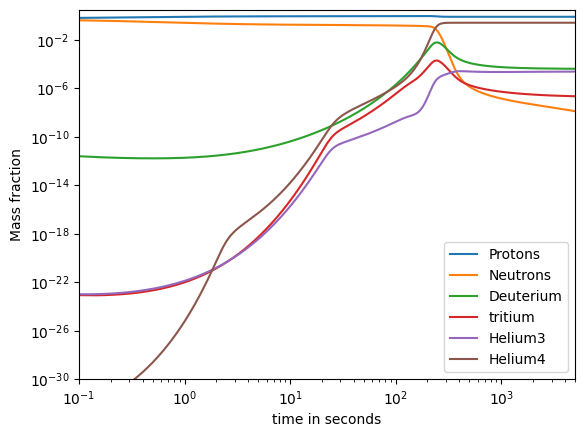

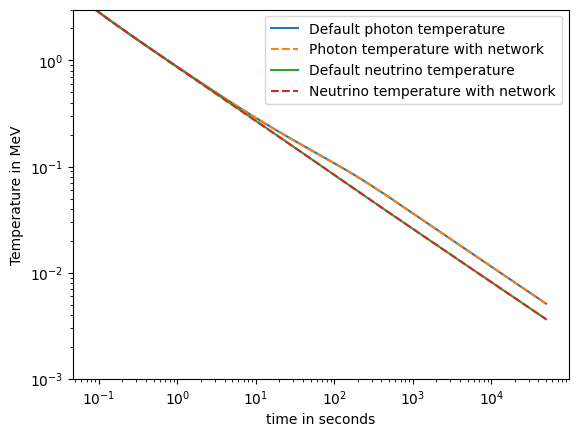

In [435]:
# Plot the results
'''
plt.figure('abundance')
plt.plot(jacsolY.t/timeunit, jacsolY.y[n_bparams+1], label='Protons')
plt.plot(jacsolY.t/timeunit, jacsolY.y[n_bparams], label='Neutrons')
plt.plot(jacsolY.t/timeunit, 2*jacsolY.y[n_bparams+2], label='Deuterium')
plt.plot(jacsolY.t/timeunit, 3*jacsolY.y[n_bparams+3], label='tritium')
plt.plot(jacsolY.t/timeunit, 3*jacsolY.y[n_bparams+4], label='Helium3')
plt.plot(jacsolY.t/timeunit, 4*jacsolY.y[n_bparams+5], label='Helium4')
plt.plot(jacsolY.t/timeunit, 4*jacsolY.y[n_bparams+6], label='Lithium6')
plt.plot(jacsolY.t/timeunit, 4*jacsolY.y[n_bparams+8], label='Berylium7')
#plt.plot(solY.t/timeunit, [1e-4 for t in solY.t], 'k+',label='eval test')
#plt.plot(sol.t, sol.y[3]/sol.y[2], label='n/p')
'''



plt.figure('abundance')
plt.plot(solY_ini.t+t_ini/timeunit, solY_ini.y[n_bparams+1], label='Protons')
plt.plot(solY_ini.t+t_ini/timeunit, solY_ini.y[n_bparams], label='Neutrons')
plt.plot(solY_ini.t+t_ini/timeunit, 2*solY_ini.y[n_bparams+2], label='Deuterium')
plt.plot(solY_ini.t+t_ini/timeunit, 3*solY_ini.y[n_bparams+3], label='tritium')
plt.plot(solY_ini.t+t_ini/timeunit, 3*solY_ini.y[n_bparams+4], label='Helium3')
plt.plot(solY_ini.t+t_ini/timeunit, 4*solY_ini.y[n_bparams+5], label='Helium4')


#print(solY.y[n_bparams:])
#print(solY)
plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
#plt.ylim(1e-15,3)
#plt.xlim(t_ini/timeunit,1e4)
plt.ylim(1e-30,3)
plt.xlim(0.1,5e3)

plt.xscale('log')
plt.yscale('log')

#plt.xlim((1, 5e4))
#plt.ylim((1e-10,1.1))

plt.legend()
plt.show()

plt.figure('temperature')

# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Default photon temperature')
plt.plot(solY_ini.t+t_ini/timeunit, solY_ini.y[0],'--', label='Photon temperature with network')

# Test with completely radiation dominated universe
#t_space=solY.t
#T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(sol.t/timeunit, T_ini/sol.y[1], label='Default neutrino temperature')
plt.plot(solY_ini.t+t_ini/timeunit, T_ini/solY_ini.y[1],'--', label='Neutrino temperature with network')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()
